### Protein Family Classification

In [1]:
import pandas as pd
import tensorflow as tf

import tarfile
import re
import urllib.request
import os
import random

import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from lazy import lazy

In [2]:
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
family_classification_metadata = pd.read_table('../hw5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../hw5/data/family_classification_sequences.tab')

In [4]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [6]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_DEN3C,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


In [7]:
family_cnt_exmp = dict()
for i in range(len(family_classification_metadata)):
    cur_fam_id = family_classification_metadata["FamilyID"][i]
    if (cur_fam_id not in family_cnt_exmp):
        family_cnt_exmp[cur_fam_id] = 0
    family_cnt_exmp[cur_fam_id] += 1

familys_sort = []
for k, v in family_cnt_exmp.items():
    familys_sort.append((v, k))
familys_sort.sort(reverse=True)

most_frequent_families = []
for i in range(1000):
    most_frequent_families.append(familys_sort[i][1])

print(most_frequent_families)

['MMR_HSR1', 'Helicase_C', 'ATP-synt_ab', '7tm_1', 'AA_kinase', 'AAA', 'tRNA-synt_1', 'tRNA-synt_2', 'MFS_1', 'HSP70', 'Oxidored_q1', 'His_biosynth', 'Cpn60_TCP1', 'EPSP_synthase', 'Aldedh', 'Shikimate_DH', 'GHMP_kinases_N', 'Ribosomal_S2', 'Ribosomal_S4', 'Ribosomal_L16', 'KOW', 'UPF0004', 'Ribosom_S12_S23', 'GHMP_kinases_C', 'Ribosomal_S14', 'Ribosomal_S11', 'UVR', 'Ribosomal_L33', 'BRCT', 'RF-1', 'Ank_2', 'Ribosomal_L20', 'RNA_pol_Rpb2_1', 'Ribosomal_S18', 'ATP-synt_B', 'Peptidase_M20', 'Ribosomal_L18e', 'GIDA', 'Oxidored_q2', 'Ldh_1_N', 'HD', 'Ribosomal_S10', 'PALP', 'Ribosomal_L18p', 'Ribosomal_L3', 'tRNA-synt_1g', 'UbiA', 'Ribosomal_L4', 'Ribosomal_S16', 'Ribosomal_S13', 'Methyltransf_5', 'Ribosomal_L32p', 'EF_TS', 'THF_DHG_CYH', 'OSCP', 'tRNA-synt_1e', 'SecA_SW', 'Ribosomal_L31', 'RNase_HII', 'Ribosomal_L27', 'IPPT', 'LepA_C', 'Ribosomal_L17', 'Ribosomal_L23', 'Ribosomal_L10', 'Ribosomal_L19', 'Ribosomal_S20p', 'Ribosomal_L35p', 'PGM_PMM_IV', 'AMP-binding', 'Ribosomal_L21p', 'tR

In [8]:
families_protein_id_list = dict()
for i in range(1000):
    families_protein_id_list[most_frequent_families[i]] = []

for i in range(len(family_classification_metadata)):
    cur_fam_id = family_classification_metadata["FamilyID"][i]
    if (cur_fam_id in families_protein_id_list):
        families_protein_id_list[cur_fam_id].append(i)

train_id = []
test_id = []
        
for i in range(1000):
    random.shuffle(families_protein_id_list[most_frequent_families[i]])
    cnt_train = len(families_protein_id_list[most_frequent_families[i]]) * 8//10
    for j in range(cnt_train):
        train_id.append(families_protein_id_list[most_frequent_families[i]][j])
    for j in range(cnt_train, len(families_protein_id_list[most_frequent_families[i]])):
        test_id.append(families_protein_id_list[most_frequent_families[i]][j])
random.shuffle(train_id)
random.shuffle(test_id)

print("train", train_id)
print("test", test_id)

train [86110, 79694, 288694, 230307, 100354, 300711, 282250, 141363, 63431, 2511, 132578, 169656, 235969, 78249, 201825, 43892, 58773, 176274, 146058, 127992, 206559, 299210, 276719, 171451, 242980, 212616, 262239, 60030, 276494, 204563, 125222, 4584, 314596, 198409, 22921, 58543, 100103, 273348, 236669, 172177, 242499, 183892, 201895, 180753, 286433, 129126, 137156, 167598, 128327, 82239, 101772, 215784, 228134, 12470, 76359, 6948, 205229, 154229, 109382, 74575, 32159, 160827, 255805, 259991, 272640, 206335, 160349, 266219, 251617, 224422, 140651, 182017, 9536, 12157, 6401, 14114, 106929, 215119, 154830, 265459, 20694, 140681, 303528, 190007, 149614, 189781, 223867, 214596, 127653, 78860, 128057, 158366, 174006, 103173, 146422, 261116, 77963, 238377, 265213, 284179, 63859, 317642, 320438, 200803, 95447, 130976, 251226, 189881, 148715, 124832, 224301, 239263, 316973, 31547, 121666, 140808, 197115, 285399, 239230, 198794, 80504, 187165, 165865, 256465, 133934, 78640, 313018, 149312, 222

In [9]:
embed_matrix = pd.read_csv("protVec_100d_3grams.csv", sep='\\t', header=None, engine='python', index_col=0)
embed_matrix.head()
print(embed_matrix)

            1         2         3         4         5         6         7    \
0                                                                             
AAA   -0.174060 -0.095756  0.059515  0.039673 -0.375934 -0.115415  0.090725   
ALA   -0.114085 -0.093288  0.155800 -0.037351 -0.121446  0.084037  0.023819   
LLL   -0.075594 -0.100834 -0.046616 -0.208980 -0.008596 -0.038612 -0.049360   
LAA   -0.137546 -0.135425  0.121566 -0.038295 -0.212129  0.040009  0.078545   
AAL   -0.156112 -0.133524  0.114426 -0.020264 -0.058513  0.057005  0.076881   
ALL   -0.056191 -0.144594  0.043214 -0.146754 -0.058094  0.024076  0.074966   
LLA   -0.177890 -0.001898  0.032638 -0.053407 -0.036736 -0.021239 -0.013052   
LAL   -0.188611 -0.002185  0.108836 -0.126098 -0.001931 -0.017215 -0.056647   
SSS    0.012405 -0.368833 -0.368951 -0.212781 -0.227907 -0.243726  0.056344   
EAL   -0.143734 -0.074760 -0.033182  0.061196 -0.107497  0.112890  0.055947   
AAG   -0.122047 -0.131051  0.082267  0.007056 -0.133

In [10]:
seq_to_id = dict()
id_list = embed_matrix.index.tolist();
for i in range(len(embed_matrix)):
    seq_to_id[id_list[i]] = i

print(seq_to_id)

{'AAA': 0, 'ALA': 1, 'LLL': 2, 'LAA': 3, 'AAL': 4, 'ALL': 5, 'LLA': 6, 'LAL': 7, 'SSS': 8, 'EAL': 9, 'AAG': 10, 'LGL': 11, 'LLS': 12, 'ELL': 13, 'LLE': 14, 'LLG': 15, 'SLL': 16, 'VAA': 17, 'LAE': 18, 'GGG': 19, 'AGL': 20, 'EEL': 21, 'AVA': 22, 'EEE': 23, 'LSL': 24, 'VLA': 25, 'ALG': 26, 'AAV': 27, 'LAG': 28, 'VLL': 29, 'GLL': 30, 'EAA': 31, 'AGA': 32, 'LLD': 33, 'ELA': 34, 'LEE': 35, 'ALE': 36, 'AVL': 37, 'LLK': 38, 'AEA': 39, 'AEL': 40, 'GLA': 41, 'LEA': 42, 'EKL': 43, 'RLL': 44, 'ALV': 45, 'ALR': 46, 'LGA': 47, 'LEK': 48, 'LKE': 49, 'AAE': 50, 'LVA': 51, 'DLL': 52, 'LLV': 53, 'LLR': 54, 'LVL': 55, 'LAR': 56, 'SSL': 57, 'LAS': 58, 'KLL': 59, 'GAA': 60, 'SAL': 61, 'TLL': 62, 'RAL': 63, 'LSA': 64, 'LAK': 65, 'DAL': 66, 'VAL': 67, 'GAG': 68, 'ALS': 69, 'AAR': 70, 'LSS': 71, 'LSG': 72, 'KAL': 73, 'SLA': 74, 'LAV': 75, 'LAD': 76, 'LGG': 77, 'ASL': 78, 'AIA': 79, 'RLA': 80, 'AGV': 81, 'SLS': 82, 'KEL': 83, 'LLT': 84, 'GAL': 85, 'VVA': 86, 'ERL': 87, 'LDL': 88, 'LEL': 89, 'ELE': 90, 'AAS': 9

In [11]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(embed_matrix)


tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
tsne_df.head()

,x0,x1
0,3.448284,-3.949775
1,2.758263,-4.583681
2,1.407525,-5.544826
3,2.729012,-4.329892
4,2.790550,-4.428670


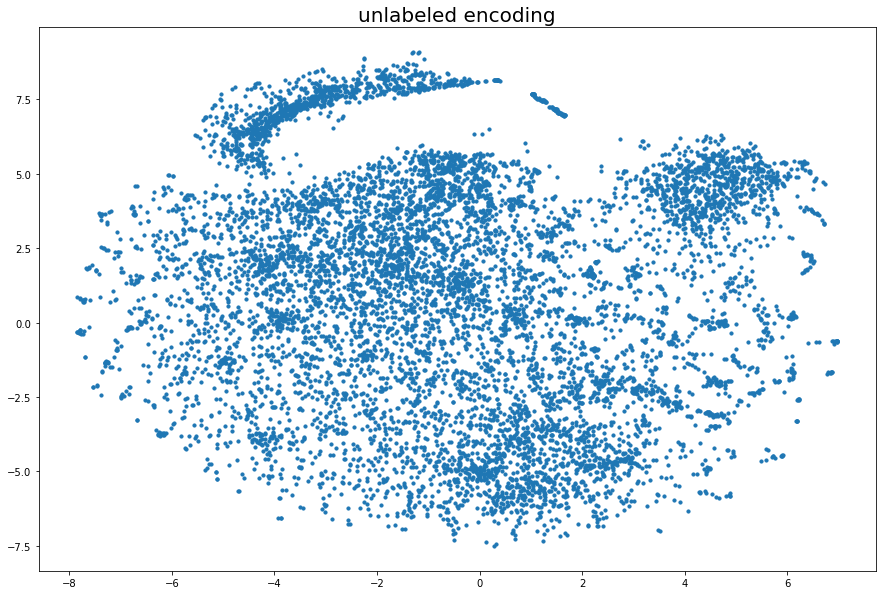

In [12]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

plot_tsne_df(tsne_df)

In [13]:
def acid_dict(seq, family):
    x0 = 0
    x1 = 0
    for i in range(0,len(seq),3):
        subseq = seq[i:i + 3]
        if (len(subseq) == 3):
            x0 += tsne_df["x0"][seq_to_id[subseq]]
            x1 += tsne_df["x1"][seq_to_id[subseq]]
    
    dres = dict()
    dres["x0"] = x0
    dres["x1"] = x1
    dres["fam"] = family
    return dres

p0 = most_frequent_families[0]
p1 = most_frequent_families[1] 
all_prot_dict = []
for i in range(len(family_classification_metadata)):
    if (family_classification_metadata["FamilyID"][i] == p0):
        all_prot_dict.append(acid_dict(family_classification_sequences["Sequences"][i], 0))
    
    if (family_classification_metadata["FamilyID"][i] == p1):
        all_prot_dict.append(acid_dict(family_classification_sequences["Sequences"][i], 1))


all_prot_df = pd.DataFrame(all_prot_dict)
all_prot_df.head()

,fam,x0,x1
0,1,-231.135196,128.645268
1,0,-72.976207,149.635431
2,1,-102.572238,242.292548
3,1,-72.493335,85.800772
4,1,-19.806498,151.765979


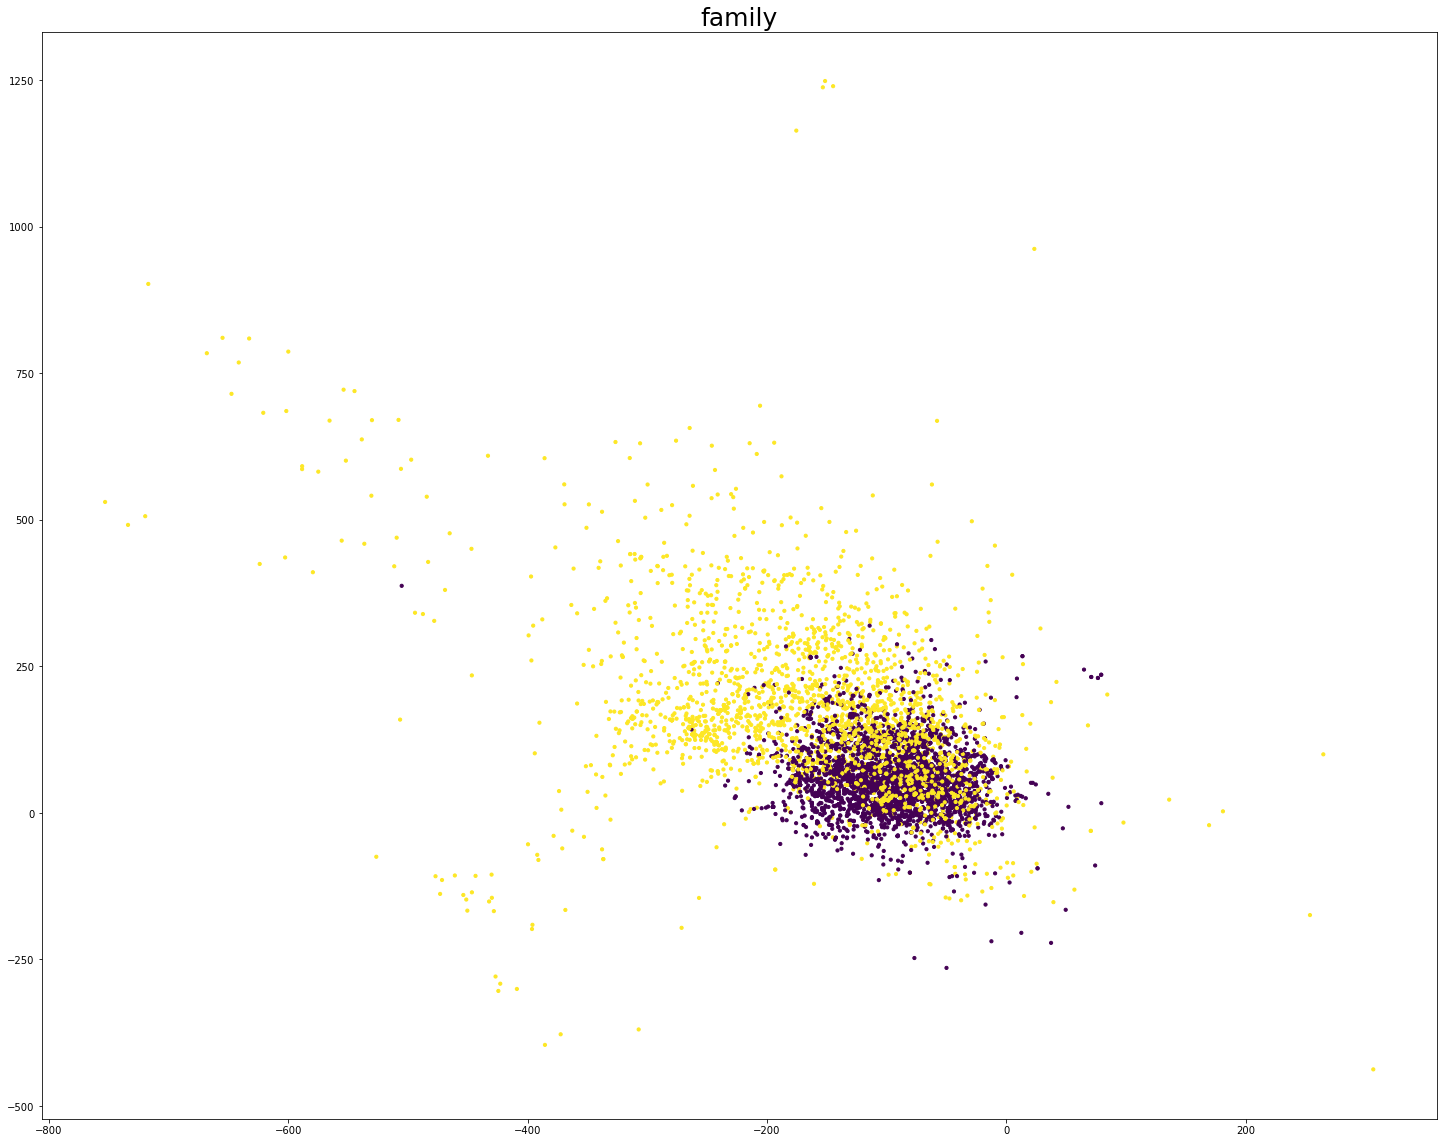

In [14]:
def plot_embedding_properties(all_prot_df):
    plt.figure(figsize=(25, 20))
    plt.title("family", fontsize=25)
    plt.scatter(all_prot_df.x0, all_prot_df.x1, c=all_prot_df.fam, s=10)
    plt.show()

plot_embedding_properties(all_prot_df)

In [15]:
class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, 1000])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

## Checkpoints

In [16]:
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'protRNN')

In [17]:
length = 0
for i in range(len(family_classification_sequences["Sequences"])):
    length = max(length, len(family_classification_sequences["Sequences"][i])//3 + 1)
print(length)

embed_len = 100

7385


In [18]:
def find_fam(sid):
    famName =  family_classification_metadata["FamilyID"][sid]
    for i in range(len(most_frequent_families)):
        if (most_frequent_families[i] == famName):
            return i
    return -1

def get_embed(sid):
    seq = family_classification_sequences["Sequences"][sid]
    data = np.zeros((length, embed_len))
    
    for i in range(0,len(seq),3):
        subseq = seq[i:i + 3]
        if subseq in seq_to_id:
            if (len(subseq) == 3):
                for j in range(1, 101):
                    data[i//3][j - 1] = embed_matrix[j][subseq]
    return data
    

In [19]:
def preprocess_batched(seq_id, batch_size):
    i = 0
    while (i < len(seq_id)):
        data = np.zeros((batch_size, length, embed_len))
        target = np.zeros((batch_size, 1000))
        
        for j in range(batch_size):
            if (i >= len(seq_id)):
                return
            sid = seq_id[i]
            i += 1
            label = find_fam(sid)
            data[j] = get_embed(sid)
            target[j][label] = 1
        yield data, target

In [21]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=100,
    optimizer=tf.train.RMSPropOptimizer(0.002),
    batch_size=256,
    gradient_clipping=100,
    seq_length=length,
    embed_length=embed_len
)

In [22]:
batches = preprocess_batched(train_id, params.batch_size)

In [ ]:
import time
from datetime import timedelta

tf.reset_default_graph()
model = SequenceClassificationModel(params)
saver = tf.train.Saver()

with tf.Session() as sess:
    start_time = time.time()
    try:
        print("Trying to restore last checkpoint ...")

        # Use TensorFlow to find the latest checkpoint - if any.
        #last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

        # Try and load the data in the checkpoint.
        saver.restore(sess, save_path="checkpoints/protRNN-7190")

        # If we get to this point, the checkpoint was successfully loaded.
        print("Restored checkpoint from:", "checkpoints/protRNN-7190")
    except:
        # If the above failed for some reason, simply
        # initialize all the variables for the TensorFlow graph.
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    for index, batch in enumerate(batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        print('{}: {:3.1f}%'.format(index + 1, 100 * error))
        if index % 1 == 0:
            summary_writer.add_summary(summary_str, index)
        if index == 7200:
            break
        if index % 10 == 0:
            saver.save(sess,
                            save_path=save_path,
                            global_step=index)
            print("Saved checkpoint.") 
    
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/protRNN-7190
Restored checkpoint from: checkpoints/protRNN-7190
1: 60.0%
Saved checkpoint.
2: 85.0%
3: 70.0%
4: 55.0%
5: 60.0%
6: 70.0%
7: 75.0%
8: 65.0%
9: 65.0%
10: 80.0%
11: 60.0%
Saved checkpoint.
12: 70.0%
13: 65.0%
14: 60.0%
15: 60.0%
16: 60.0%
17: 75.0%
18: 80.0%
19: 75.0%
20: 65.0%
21: 75.0%
Saved checkpoint.
22: 65.0%
23: 90.0%
24: 75.0%
25: 70.0%
26: 70.0%
27: 50.0%
28: 70.0%
29: 70.0%
30: 80.0%
31: 75.0%
Saved checkpoint.
32: 65.0%
33: 70.0%
34: 45.0%
35: 85.0%
36: 65.0%
37: 70.0%
38: 80.0%
39: 70.0%
40: 55.0%
41: 50.0%
Saved checkpoint.
42: 55.0%
43: 65.0%
44: 75.0%
45: 75.0%
46: 65.0%
47: 70.0%
48: 70.0%
49: 45.0%
50: 65.0%
51: 90.0%
Saved checkpoint.
52: 75.0%
53: 70.0%
54: 85.0%
55: 80.0%
56: 70.0%
57: 75.0%
58: 70.0%
59: 65.0%
60: 75.0%
61: 80.0%
Saved checkpoint.
62: 80.0%
63: 60.0%
64: 55.0%
65: 65.0%
66: 65.0%
67: 60.0%
68: 55.0%
69: 55.0%
70: 80.0%
71: 85.0%
Saved checkpoint.

637: 70.0%
638: 45.0%
639: 60.0%
640: 60.0%
641: 60.0%
Saved checkpoint.
642: 80.0%
643: 75.0%
644: 60.0%
645: 65.0%
646: 70.0%
647: 65.0%
648: 60.0%
649: 75.0%
650: 60.0%
651: 60.0%
Saved checkpoint.
652: 60.0%
653: 55.0%
654: 55.0%
655: 75.0%
656: 60.0%
657: 65.0%
658: 60.0%
659: 85.0%
660: 50.0%
661: 60.0%
Saved checkpoint.
662: 70.0%
663: 80.0%
664: 65.0%
665: 85.0%
666: 55.0%
667: 65.0%
668: 65.0%
669: 60.0%
670: 60.0%
671: 70.0%
Saved checkpoint.
672: 85.0%
673: 70.0%
674: 80.0%
675: 60.0%
676: 75.0%
677: 65.0%
678: 60.0%
679: 60.0%
680: 75.0%
681: 60.0%
Saved checkpoint.
682: 50.0%
683: 70.0%
684: 45.0%
685: 70.0%
686: 90.0%
687: 65.0%
688: 75.0%
689: 75.0%
690: 65.0%
691: 65.0%
Saved checkpoint.
692: 60.0%
693: 65.0%
694: 75.0%
695: 90.0%
696: 80.0%
697: 75.0%
698: 65.0%
699: 55.0%
700: 70.0%
701: 70.0%
Saved checkpoint.
702: 70.0%
703: 65.0%
704: 75.0%
705: 65.0%
706: 55.0%
707: 75.0%
708: 65.0%
709: 85.0%
710: 75.0%
711: 60.0%
Saved checkpoint.
712: 55.0%
713: 75.0%
714: 70.0

1257: 45.0%
1258: 65.0%
1259: 85.0%
1260: 60.0%
1261: 45.0%
Saved checkpoint.
1262: 75.0%
1263: 75.0%
1264: 75.0%
1265: 70.0%
1266: 70.0%
1267: 55.0%
1268: 50.0%
1269: 70.0%
1270: 65.0%
1271: 60.0%
Saved checkpoint.
1272: 65.0%
1273: 65.0%
1274: 65.0%
1275: 70.0%
1276: 85.0%
1277: 65.0%
1278: 60.0%
1279: 65.0%
1280: 65.0%
1281: 60.0%
Saved checkpoint.
1282: 65.0%
1283: 65.0%
1284: 85.0%
1285: 65.0%
1286: 60.0%
1287: 80.0%
1288: 75.0%
1289: 60.0%
1290: 50.0%
1291: 45.0%
Saved checkpoint.
1292: 65.0%
1293: 75.0%
1294: 55.0%
1295: 70.0%
1296: 60.0%
1297: 55.0%
1298: 55.0%
1299: 55.0%
1300: 55.0%
1301: 90.0%
Saved checkpoint.
1302: 60.0%
1303: 60.0%
1304: 55.0%
1305: 85.0%
1306: 55.0%
1307: 60.0%
1308: 55.0%
1309: 60.0%
1310: 70.0%
1311: 65.0%
Saved checkpoint.
1312: 80.0%
1313: 60.0%
1314: 65.0%
1315: 75.0%
1316: 65.0%
1317: 65.0%
1318: 65.0%
1319: 70.0%
1320: 65.0%
1321: 60.0%
Saved checkpoint.
1322: 50.0%
1323: 85.0%
1324: 70.0%
1325: 60.0%
1326: 50.0%
1327: 65.0%
1328: 70.0%
1329: 60.0

1852: 60.0%
1853: 65.0%
1854: 75.0%
1855: 55.0%
1856: 60.0%
1857: 60.0%
1858: 45.0%
1859: 65.0%
1860: 70.0%
1861: 70.0%
Saved checkpoint.
1862: 75.0%
1863: 80.0%
1864: 60.0%
1865: 40.0%
1866: 60.0%
1867: 90.0%
1868: 65.0%
1869: 70.0%
1870: 65.0%
1871: 60.0%
Saved checkpoint.
1872: 60.0%
1873: 75.0%
1874: 40.0%
1875: 70.0%
1876: 40.0%
1877: 60.0%
1878: 80.0%
1879: 80.0%
1880: 65.0%
1881: 75.0%
Saved checkpoint.
1882: 65.0%
1883: 60.0%
1884: 65.0%
1885: 60.0%
1886: 60.0%
1887: 60.0%
1888: 75.0%
1889: 75.0%
1890: 75.0%
1891: 65.0%
Saved checkpoint.
1892: 50.0%
1893: 70.0%
1894: 55.0%
1895: 65.0%
1896: 50.0%
1897: 65.0%
1898: 60.0%
1899: 65.0%
1900: 70.0%
1901: 75.0%
Saved checkpoint.
1902: 60.0%
1903: 65.0%
1904: 60.0%
1905: 60.0%
1906: 85.0%
1907: 65.0%
1908: 85.0%
1909: 75.0%
1910: 65.0%
1911: 55.0%
Saved checkpoint.
1912: 80.0%
1913: 55.0%
1914: 80.0%
1915: 70.0%
1916: 55.0%
1917: 50.0%
1918: 75.0%
1919: 55.0%
1920: 75.0%
1921: 60.0%
Saved checkpoint.
1922: 60.0%
1923: 60.0%
1924: 45.0

2447: 55.0%
2448: 80.0%
2449: 60.0%
2450: 65.0%
2451: 75.0%
Saved checkpoint.
2452: 75.0%
2453: 65.0%
2454: 65.0%
2455: 65.0%
2456: 85.0%
2457: 45.0%
2458: 60.0%
2459: 50.0%
2460: 80.0%
2461: 65.0%
Saved checkpoint.
2462: 60.0%
2463: 75.0%
2464: 70.0%
2465: 70.0%
2466: 85.0%
2467: 85.0%
2468: 65.0%
2469: 70.0%
2470: 55.0%
2471: 55.0%
Saved checkpoint.
2472: 80.0%
2473: 60.0%
2474: 85.0%
2475: 60.0%
2476: 50.0%
2477: 70.0%
2478: 75.0%
2479: 65.0%
2480: 65.0%
2481: 35.0%
Saved checkpoint.
2482: 75.0%
2483: 50.0%
2484: 75.0%
2485: 75.0%
2486: 75.0%
2487: 55.0%
2488: 60.0%
2489: 65.0%
2490: 65.0%
2491: 50.0%
Saved checkpoint.
2492: 65.0%
2493: 70.0%
2494: 50.0%
2495: 85.0%
2496: 65.0%
2497: 75.0%
2498: 75.0%
2499: 75.0%
2500: 65.0%
2501: 75.0%
Saved checkpoint.
2502: 85.0%
2503: 45.0%
2504: 85.0%
2505: 80.0%
2506: 70.0%
2507: 35.0%
2508: 80.0%
2509: 75.0%
2510: 80.0%
2511: 75.0%
Saved checkpoint.
2512: 60.0%
2513: 55.0%
2514: 75.0%
2515: 60.0%
2516: 70.0%
2517: 60.0%
2518: 70.0%
2519: 75.0

3042: 70.0%
3043: 90.0%
3044: 70.0%
3045: 50.0%
3046: 55.0%
3047: 65.0%
3048: 75.0%
3049: 65.0%
3050: 70.0%
3051: 60.0%
Saved checkpoint.
3052: 65.0%
3053: 90.0%
3054: 50.0%
3055: 70.0%
3056: 65.0%
3057: 50.0%
3058: 65.0%
3059: 70.0%
3060: 75.0%
3061: 80.0%
Saved checkpoint.
3062: 65.0%
3063: 75.0%
3064: 60.0%
3065: 55.0%
3066: 75.0%
3067: 60.0%
3068: 75.0%
3069: 65.0%
3070: 65.0%
3071: 70.0%
Saved checkpoint.
3072: 75.0%
3073: 65.0%
3074: 45.0%
3075: 45.0%
3076: 65.0%
3077: 70.0%
3078: 90.0%
3079: 70.0%
3080: 45.0%
3081: 80.0%
Saved checkpoint.
3082: 65.0%
3083: 65.0%
3084: 55.0%
3085: 60.0%
3086: 85.0%
3087: 65.0%
3088: 75.0%
3089: 50.0%
3090: 55.0%
3091: 70.0%
Saved checkpoint.
3092: 70.0%
3093: 75.0%
3094: 55.0%
3095: 50.0%
3096: 55.0%
3097: 85.0%
3098: 65.0%
3099: 40.0%
3100: 65.0%
3101: 55.0%
Saved checkpoint.
3102: 60.0%
3103: 70.0%
3104: 75.0%
3105: 70.0%
3106: 55.0%
3107: 70.0%
3108: 60.0%
3109: 55.0%
3110: 65.0%
3111: 60.0%
Saved checkpoint.
3112: 85.0%
3113: 75.0%
3114: 50.0

3637: 75.0%
3638: 70.0%
3639: 70.0%
3640: 55.0%
3641: 55.0%
Saved checkpoint.
3642: 45.0%
3643: 50.0%
3644: 65.0%
3645: 65.0%
3646: 60.0%
3647: 50.0%
3648: 65.0%
3649: 70.0%
3650: 50.0%
3651: 45.0%
Saved checkpoint.
3652: 80.0%
3653: 70.0%
3654: 80.0%
3655: 85.0%
3656: 75.0%
3657: 65.0%
3658: 60.0%
3659: 70.0%
3660: 75.0%
3661: 75.0%
Saved checkpoint.
3662: 50.0%
3663: 50.0%
3664: 65.0%
3665: 60.0%
3666: 50.0%
3667: 60.0%
3668: 65.0%
3669: 55.0%
3670: 55.0%
3671: 75.0%
Saved checkpoint.
3672: 65.0%
3673: 60.0%
3674: 70.0%
3675: 55.0%
3676: 65.0%
3677: 65.0%
3678: 65.0%
3679: 55.0%
3680: 70.0%
3681: 85.0%
Saved checkpoint.
3682: 75.0%
3683: 60.0%
3684: 70.0%
3685: 65.0%
3686: 60.0%
3687: 60.0%
3688: 65.0%
3689: 60.0%
3690: 65.0%
3691: 60.0%
Saved checkpoint.
3692: 60.0%
3693: 70.0%
3694: 65.0%
3695: 70.0%
3696: 55.0%
3697: 60.0%
3698: 70.0%
3699: 70.0%
3700: 70.0%
3701: 75.0%
Saved checkpoint.
3702: 60.0%
3703: 75.0%
3704: 80.0%
3705: 55.0%
3706: 80.0%
3707: 80.0%
3708: 55.0%
3709: 70.0

In [ ]:
def getEmbed(sid):
    X = np.zeros((len(sid), 100))
    ii = 0
    for cid in sid:
        if (ii % 100 == 0): 
            print(ii, len(sid))
        seq = family_classification_sequences["Sequences"][cid]
        for i in range(0,len(seq),3):
            subseq = seq[i:i + 3]
            if (len(subseq) == 3) and (subseq in seq_to_id):
                X[ii] += np.reshape(embed_matrix.loc[[subseq]].as_matrix(), 100)
        ii += 1
    return X

def getClasses(sid):
    Y = []
    for cid in sid:
        Y.append(find_fam(cid))
    return Y

In [ ]:
trainX = getEmbed(train_id)
trainY = getClasses(train_id)

0 208531
100 208531
200 208531
300 208531
400 208531
500 208531
600 208531
700 208531
800 208531
900 208531
1000 208531
1100 208531
1200 208531
1300 208531
1400 208531
1500 208531
1600 208531
1700 208531
1800 208531
1900 208531
2000 208531
2100 208531
2200 208531
2300 208531
2400 208531
2500 208531
2600 208531
2700 208531
2800 208531
2900 208531
3000 208531
3100 208531
3200 208531
3300 208531
3400 208531
3500 208531
3600 208531
3700 208531
3800 208531
3900 208531
4000 208531
4100 208531
4200 208531
4300 208531
4400 208531
4500 208531
4600 208531
4700 208531
4800 208531
4900 208531
5000 208531
5100 208531
5200 208531
5300 208531
5400 208531
5500 208531
5600 208531
5700 208531
5800 208531
5900 208531
6000 208531
6100 208531
6200 208531
6300 208531
6400 208531
6500 208531
6600 208531
6700 208531
6800 208531
6900 208531
7000 208531
7100 208531
7200 208531
7300 208531
7400 208531
7500 208531
7600 208531
7700 208531
7800 208531
7900 208531
8000 208531
8100 208531
8200 208531
8300 208531
8400

63900 208531
64000 208531
64100 208531
64200 208531
64300 208531
64400 208531
64500 208531
64600 208531
64700 208531
64800 208531
64900 208531
65000 208531
65100 208531
65200 208531
65300 208531
65400 208531
65500 208531
65600 208531
65700 208531
65800 208531
65900 208531
66000 208531
66100 208531
66200 208531
66300 208531
66400 208531
66500 208531
66600 208531
66700 208531
66800 208531
66900 208531
67000 208531
67100 208531
67200 208531
67300 208531
67400 208531
67500 208531
67600 208531
67700 208531
67800 208531
67900 208531
68000 208531
68100 208531
68200 208531
68300 208531
68400 208531
68500 208531
68600 208531
68700 208531
68800 208531
68900 208531
69000 208531
69100 208531
69200 208531
69300 208531
69400 208531
69500 208531
69600 208531
69700 208531
69800 208531
69900 208531
70000 208531
70100 208531
70200 208531
70300 208531
70400 208531
70500 208531
70600 208531
70700 208531
70800 208531
70900 208531
71000 208531
71100 208531
71200 208531
71300 208531
71400 208531
71500 208531

125000 208531
125100 208531
125200 208531
125300 208531
125400 208531
125500 208531
125600 208531
125700 208531
125800 208531
125900 208531
126000 208531
126100 208531
126200 208531
126300 208531
126400 208531
126500 208531
126600 208531
126700 208531
126800 208531
126900 208531
127000 208531
127100 208531
127200 208531
127300 208531
127400 208531
127500 208531
127600 208531
127700 208531
127800 208531
127900 208531
128000 208531
128100 208531
128200 208531
128300 208531
128400 208531
128500 208531
128600 208531
128700 208531
128800 208531
128900 208531
129000 208531
129100 208531
129200 208531
129300 208531
129400 208531
129500 208531
129600 208531
129700 208531
129800 208531
129900 208531
130000 208531
130100 208531
130200 208531
130300 208531
130400 208531
130500 208531
130600 208531
130700 208531
130800 208531
130900 208531
131000 208531
131100 208531
131200 208531
131300 208531
131400 208531
131500 208531
131600 208531
131700 208531
131800 208531
131900 208531
132000 208531
132100

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(trainX, trainY)

In [ ]:
testX = getEmbed(test_id)
ypred = clf.predict(testX)
print(ypred)

In [ ]:
testY = getClasses(test_id)
print(testY)

In [ ]:
def preprocess_test(seq_id):
    data = np.zeros((20, length, embed_len))
        
    for j in range(256):
        sid = seq_id[j]
        data[j] = get_embed(sid)
    return data

In [ ]:
yrnnpred = []
btch_size = 256
with tf.Session() as sess:
    try:
        print("Trying to restore last checkpoint ...")

        # Use TensorFlow to find the latest checkpoint - if any.
        #last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

        # Try and load the data in the checkpoint.
        saver.restore(sess, save_path="checkpoints/protRNN-7190")

        # If we get to this point, the checkpoint was successfully loaded.
        print("Restored checkpoint from:", "checkpoints/protRNN-7190")
    except:
        # If the above failed for some reason, simply
        # initialize all the variables for the TensorFlow graph.
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())
        
    for j in range(0, len(test_id), btch_size):
        print(j, len(test_id))
        data = np.zeros((min(btch_size, len(test_id) - j), length, embed_len))
        for g in range(min(btch_size, len(test_id) - j)):
            data[g] = get_embed(test_id[g + j])
        feed = {model.data: data}
        yprd = sess.run(model.prediction, feed)
        for g in range(min(btch_size, len(test_id) - j)):
            yrnnpred.append(np.argmax(yprd[g]))

print(yrnnpred)

In [ ]:
from sklearn.metrics import accuracy_score

accuracyRF = accuracy_score(testY, ypred)
print("Random Forest accuracy: %.2f%%" % (accuracyRF * 100.0))


accuracyRNN = accuracy_score(testY, yrnnpred)
print("RNN accuracy: %.2f%%" % (accuracyRNN * 100.0))

In [40]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


#dtrain = xgb.DMatrix(trainX, label=trainY)

In [42]:
model = XGBClassifier(silent=True)
model.fit(trainX, trainY)
#param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
#bst = xgb.train(param, dtrain, 10)

KeyboardInterrupt: 

In [ ]:
ypred = bst.predict(getEmbed(test_id))
print(ypred)
testY = getClasses(test_id)
print(testY)

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

scaling = StandardScaler()
scaling.fit(trainX)
trainX = scaling.transform(trainX)

In [ ]:
clf = svm.SVC()
clf.fit(trainX, trainY)

In [ ]:
testX = getEmbed(test_id)
testX = scaling.transform(testX)

testY = getClasses(test_id)

predictY = clf.predict(testX)
print(predictY)
print(testY)

#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you